In [70]:
import torch
import torchvision
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
import torch.nn.functional as F

import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt

### EDA

In [4]:
rat = pd.read_csv('../data/Movie Lens/ml-latest-small/ratings.csv')
mov = pd.read_csv('../data/Movie Lens/ml-latest-small/movies.csv')

In [6]:
rat.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
mov.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_combined = pd.merge(rat, mov, on = 'movieId')

In [8]:
df_combined.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [9]:
# Divide dataset into train / validataion (98% vs 2%)
ts = rat['timestamp'].quantile(0.98)
ts

1529334436.3000002

In [10]:
train_ratings = pd.DataFrame(columns=['userId','movieId','rating'])
validation_ratings = pd.DataFrame(columns=['userId','movieId','rating'])
for i in range(len(rat)):
    if rat['timestamp'].iloc[i] <= ts:
        train_ratings = train_ratings.append([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])
        validation_ratings = validation_ratings.append([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])
    else:
        validation_ratings = validation_ratings.append([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])

    if i%10000 == 0:
        print(i, "Completed")

0 Completed
10000 Completed
20000 Completed
30000 Completed
40000 Completed
50000 Completed
60000 Completed
70000 Completed
80000 Completed
90000 Completed
100000 Completed


In [11]:
train_ratings.head()

,userId,movieId,rating
0,1,1,4.0
0,1,3,4.0
0,1,6,4.0
0,1,47,5.0
0,1,50,5.0


In [12]:
train_ratings = train_ratings.reset_index(drop=True)
validation_ratings = validation_ratings.reset_index(drop=True)

In [14]:
# Remove users in validation set those are not present in Training Set
train_users = train_ratings['userId'].unique()
users_not_in_train_set = []

for i in range(1,611):
    if i in train_users:
        continue
    else:
        users_not_in_train_set.append(i)
        
users_not_in_train_set

[25, 77, 98, 184, 248, 258, 272, 296, 331, 338, 362, 514, 556, 586, 596]

In [15]:
for i in users_not_in_train_set:
    validation_ratings = validation_ratings[validation_ratings['userId']!=i]
    
validation_ratings.reset_index(drop=True)
validation_ratings['userId'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 204, 205, 20

In [17]:
# Remove Movies that are not in the Train Set
validation_movies = validation_ratings['movieId'].unique()
train_movies = train_ratings['movieId'].unique()
movies_not_in_train_set = []

for i in validation_movies:
    if i in train_movies:
        continue
    else:
        movies_not_in_train_set.append(i)
        
movies_not_in_train_set

[166015,
 4282,
 46862,
 111732,
 164280,
 188301,
 190183,
 77795,
 119167,
 130444,
 159779,
 166203,
 179511,
 188751,
 78103,
 185585,
 26713,
 49917,
 102742,
 117364,
 143896,
 150696,
 159976,
 173317,
 179135,
 188675,
 188833,
 189381,
 2656,
 27683,
 95473,
 96007,
 103233,
 104141,
 134524,
 137863,
 151763,
 161354,
 172875,
 176935,
 179119,
 182639,
 187541,
 179813,
 183199,
 184721,
 187717,
 188189,
 189713]

In [18]:
for i in movies_not_in_train_set:
    validation_ratings = validation_ratings[validation_ratings['movieId']!=i]

validation_ratings.reset_index(drop=True)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
99002,610,166534,4.0
99003,610,168248,5.0
99004,610,168250,5.0
99005,610,168252,5.0


In [20]:
validation_ratings.loc[validation_ratings['movieId']== 168250]

,userId,movieId,rating
9137,62,168250,4.0
15941,103,168250,3.0
19581,125,168250,4.0
30500,212,168250,2.5
46727,306,168250,3.0
54878,363,168250,4.0
65202,417,168250,3.0
71989,462,168250,5.0
81499,515,168250,4.5
88158,567,168250,2.0


In [21]:
print('Train Users: ', train_ratings['userId'].nunique())
print('Validation Users: ',validation_ratings['userId'].nunique())
print('Train Movies: ',train_ratings['movieId'].nunique())
print('Validation Movies: ',validation_ratings['movieId'].nunique())

Train Users:  595
Validation Users:  595
Train Movies:  9559
Validation Movies:  9559


In [23]:
train_ratings.to_csv("train_ratings.csv")
validation_ratings.to_csv("validation_ratings.csv")

In [24]:
tr_ratings = pd.read_csv('train_ratings.csv')
val_ratings = pd.read_csv('validation_ratings.csv')

In [25]:
train_dataset = tr_ratings.pivot_table(index = 'userId', columns = 'movieId', values = 'rating')
train_dataset.fillna(0, inplace=True)
train_dataset.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,184349,184471,184791,185029,185031,185135,185435,187593,187595,189547
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
test_dataset = val_ratings.pivot_table(index='userId', columns='movieId', values='rating')
test_dataset.fillna(0, inplace=True)
test_dataset.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,184349,184471,184791,185029,185031,185135,185435,187593,187595,189547
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
train_dataset.to_csv("train.csv")
test_dataset.to_csv('test.csv')

In [42]:
import torchvision
import torchvision.transforms as transforms


class TrainDataset(Dataset):
    def __init__(self, train_file, transforms=None):
        self.data = pd.read_csv(train_file)
        self.data = self.data.iloc[:,1:]
        self.transforms = transforms

        if transforms is not None:
            self.data = self.transforms(np.array(self.data))

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]

        return user_vector

In [138]:
transformations = transforms.Compose([transforms.ToTensor()])
train_dat = TrainDataset('train.csv', transformations)

In [139]:
class TestDataset(Dataset):
    def __init__(self, test_file, transform=None):
        self.data = pd.read_csv(test_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform

        if transform is not None:
            self.data = self.transform(np.array(self.data))

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]

        return user_vector

In [140]:
test_dat = TestDataset('test.csv', transformations)

In [141]:
train = DataLoader(dataset=train_dat, batch_size = 128, shuffle=True)
test = DataLoader(dataset=test_dat, batch_size=128, shuffle=True)

In [124]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [128]:
train, test

(<torch.utils.data.dataloader.DataLoader at 0x232378331c8>,
 <torch.utils.data.dataloader.DataLoader at 0x23237833cc8>)

In [76]:
class AutoEncoder(nn.Module):
    def __init__(self, layer_sizes, nl_type='selu', is_constrained=True, dp_drop_prob=0.0, last_layer_activations=True):
        super(AutoEncoder, self).__init__()
        
        self.layer_sizes=layer_sizes
        self.nl_type = nl_type
        self.is_constrained = is_constrained
        self.dp_drop_prob = dp_drop_prob
        self.last_layer_activations = last_layer_activations
        
        if dp_drop_prob>0:
            self.drop = nn.Dropout(dp_drop_prob)
            
        self._last = len(layer_sizes)-2
        
        self._last = len(layer_sizes) - 2

        # Initaialize Weights
        self.encoder_weights = nn.ParameterList( [nn.Parameter(torch.rand(layer_sizes[i+1], layer_sizes[i])) for i in range(len(layer_sizes) - 1)  ] )

        # "Xavier Initialization" ( Understanding the Difficulty in training deep feed forward neural networks - by Glorot, X. & Bengio, Y. )
        # ( Values are sampled from uniform distribution )
        for weights in self.encoder_weights:
            init.xavier_uniform_(weights)

        # Encoder Bias
        self.encoder_bias = nn.ParameterList( [nn.Parameter(torch.zeros(layer_sizes[i+1])) for i in range(len(layer_sizes) - 1) ] )

        reverse_layer_sizes = list(reversed(layer_sizes)) 
        # reversed returns iterator


        # Decoder Weights
        if is_constrained == False:
            self.decoder_weights = nn.ParameterList( [nn.Parameter(torch.rand(reverse_layer_sizes[i+1], reverse_layer_sizes[i])) for i in range(len(reverse_layer_sizes) - 1) ] )

            for weights in self.decoder_weights:
                init.xavier_uniform_(weights)

        self.decoder_bias = nn.ParameterList( [nn.Parameter(torch.zeros(reverse_layer_sizes[i+1])) for i in range(len(reverse_layer_sizes) - 1) ] )



    def encode(self,x):
        for i,w in enumerate(self.encoder_weights):
            x = F.linear(input=x, weight = w, bias = self.encoder_bias[i] )
            x = F.selu(x)

        # Apply Dropout on the last layer
        if self.dp_drop_prob > 0:
            x = self.drop(x)

        return x


    def decode(self,x):
        if self.is_constrained == True:
            # Weights are tied
            for i,w in zip(range(len(self.encoder_weights)),list(reversed(self.encoder_weights))):
                x = F.linear(input=x, weight=w.t(), bias = self.decoder_bias[i] )
                x = F.selu(x)

        else:

            for i,w in enumerate(self.decoder_weights):
                x = F.linear(input=x, weight = w, bias = self.decoder_weights[i])
                x =F.selu(x)

        return x

    def forward(self,x):
        # Forward Pass
        return self.decode(self.encode(x))

In [63]:
class MSEloss_with_Mask(nn.Module):
    def __init__(self):
        super(MSEloss_with_Mask,self).__init__()
        
    def forward(self,inputs, targets):
        # Masking into a vector of 1's and 0's.
        mask = (targets!=0)
        mask = mask.float()

        # Actual number of ratings.
        # Take max to avoid division by zero while calculating loss.
        other = torch.Tensor([1.0])
        other = other.cuda()
        number_ratings = torch.max(torch.sum(mask),other)
        error = torch.sum(torch.mul(mask,torch.mul((targets-inputs),(targets-inputs))))
        loss = error.div(number_ratings)
        return loss[0]

In [152]:
layer_sizes = [9559, 512, 512, 1024]

In [160]:
model = AutoEncoder(layer_sizes=layer_sizes, nl_type='selu', is_constrained=True, dp_drop_prob=0.8, last_layer_activations=False)

In [161]:
model = model.cuda()

In [162]:
criterion = MSEloss_with_Mask()
criterion = criterion.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [114]:
for epoch in range(100):
    train_loss, valid_loss = [], []
    logs = {}
    prefix = ''

    # Training Part
    model.train()
    for i, data in enumerate(train, 0):
        # Get the inputs
        inputs = labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        inputs = inputs.float()
        labels = labels.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.cuda()
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        ## -> Iterative Dense Output Re-feeding <- ##

        # Add a "for" loop to iterate as much you want

        # Zero the gradiants
        optimizer.zero_grad()

        # Important -> detach() the output, to avoid unecessary construction of 
        # the computational graph
        outputs = model(outputs.detach())
        outputs = outputs.cuda()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        logs[prefix + 'MMSE loss'] = loss.item()

    for i, data in enumerate(test, 0):
        model.eval()
        inputs = labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        inputs = inputs.float()
        labels = labels.float()

        outputs = model(inputs)
        outputs = outputs.cuda()
        loss = criterion(outputs, labels)

        valid_loss.append(loss.item())
        prefix = 'val_'
        logs[prefix + 'MMSE loss'] = loss.item()

    if(epoch%10 ==0):
        print ("Epoch:", epoch+1, " Training Loss: ", np.mean(train_loss), " Valid Loss: ", np.mean(valid_loss))
    

Epoch: 1  Training Loss:  28.825829315185548  Valid Loss:  28.783792877197264
Epoch: 11  Training Loss:  28.74799919128418  Valid Loss:  28.78504867553711
Epoch: 21  Training Loss:  28.709093475341795  Valid Loss:  28.64393768310547
Epoch: 31  Training Loss:  28.679018402099608  Valid Loss:  28.725688552856447
Epoch: 41  Training Loss:  28.81822738647461  Valid Loss:  28.741985321044922
Epoch: 51  Training Loss:  28.64139633178711  Valid Loss:  28.7814208984375
Epoch: 61  Training Loss:  28.648042678833008  Valid Loss:  28.728428649902344
Epoch: 71  Training Loss:  28.72870216369629  Valid Loss:  28.723069763183595
Epoch: 81  Training Loss:  28.763965225219728  Valid Loss:  28.819347381591797
Epoch: 91  Training Loss:  28.67138671875  Valid Loss:  28.7306339263916


In [163]:
def train_AE(model, criterion, optimizer, train_dl, test_dl, num_epochs=40):
    # We will run for 40 epochs
    liveloss = PlotLosses()
    
#     self.train_dl = train_dl
#     self.test_dl = test_dl
#     self.optimizer = optimizer
#     self.cirerion = criterion
    for epoch in range(num_epochs):
        train_loss=[]
        valid_loss = []
        lr2_tr_loss = []
        lr2_val_loss= []
        logs = {}
        prefix = ''

        # Training Part
        model.train()
        for i, data in enumerate(train_dl, 0):
            # Get the inputs
            inputs = labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            inputs = inputs.float()
            labels = labels.float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            outputs = outputs.cuda()
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            ## -> Iterative Dense Output Re-feeding <- ##

            # Add a "for" loop to iterate as much you want

            # Zero the gradiants
            optimizer.zero_grad()

            # Important -> detach() the output, to avoid unecessary construction of 
            # the computational graph
            outputs = model(outputs.detach())
            outputs = outputs.cuda()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            logs[prefix + 'MMSE loss'] = loss.item()

        for i, data in enumerate(test_dl, 0):
            model.eval()
            inputs = labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            inputs = inputs.float()
            labels = labels.float()

            outputs = model(inputs)
            outputs = outputs.cuda()
            loss = criterion(outputs, labels)

            valid_loss.append(loss.item())
            prefix = 'val_'
            logs[prefix + 'MMSE loss'] = loss.item()

        lr2_tr_loss.append(np.mean(train_loss))
        lr2_val_loss.append(np.mean(valid_loss))
        liveloss.update(logs)
        liveloss.draw()
        print ("Epoch:", epoch+1, " Training Loss: ", np.mean(train_loss), " Valid Loss: ", np.mean(valid_loss))
        if epoch == num_epochs -1:
            return outputs

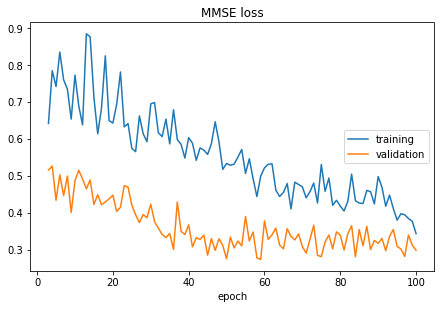

MMSE loss:
training   (min:    0.344, max:    0.884, cur:    0.344)
validation (min:    0.273, max:    0.578, cur:    0.298)
Epoch: 100  Training Loss:  0.3857060134410858  Valid Loss:  0.3199818849563599


In [165]:
from livelossplot import PlotLosses

out = train_AE(model, criterion, optimizer,train, test, 100)